# The Solov Model with productive externalities

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
#import modelproject

# Import our class
#from modelproject import modelprojectclass

# We now define our model 
#model = modelprojectclass()

#par = model.par

# Model description

The model is described as:

1. $K_t$ is capital
2. $L_t$ is labor (growing with a constant rate of $n$)
3. $A_t$ is technology (growing with a constant rate of $g$)
4. $Y_t = F(K_t,A_tL_t)$ is GDP

**GDP** is given as
$$ 
Y_t = K_t^\alpha(A_t L_t)^{1-\alpha}, \alpha > 0
$$

The **production function** has **constant-return to scale**

**Saving** is a constant fraction of GDP
$$ 
S_t = sY_t,\,s\in(0,1)
$$

such that **capital accumulates** according to

$$
K_{t+1}=S_{t}+(1-\delta)K_{t}, \delta\in(0,1)
$$

**Labor** is assumed to be the whole population
$$
L_{t+1}=(1 + n) L_t, n \geq 0
$$

**Technology** is described as
$$
A_{t+1}= K_t^\phi, \phi > 0
$$

The **techonology** function is what distinguish this model from a normal Solow Model, since this function assumes productive externalities from capital.



## The Steady State

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

As mentioned previosly, if $\phi = 0$, then the model above is just the basic Solow model. We will therefore assume $\phi < 1$, and there will therefore be diminishing return to capital alone. This means that $A_t$ is not growing at an exogenous rate, but instead it is enodgenous and depends on $K_t$ and how it evolves. 

We want to find the steady state function, we therefore use **sympy** to find an analytical expression for the steady state, i.e. we solve the transition equation for $k_t$:
$$
k_{t+1} = \frac{1}{(1+n)}*k_t[sk_{t}^{\alpha-1}+(1-\delta)]^{1-\phi}
$$

The small letters represents per capita terms. 

Since we have assumed that $\phi < 1$ the equation above is well defined and positive. Also notice that if $\phi = 0$ we will get something equivalent to the transition equation of the basic Solow Model.

In [2]:
# We start out by defining the symbols
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
phi = sm.symbols('phi')
s = sm.symbols('s')
n = sm.symbols('n')
k = sm.symbols('k')

In [3]:
# In order to find an analytical expression for the steady state, we need to solve for k in the transition function
ss = sm.Eq(k, (1/(1+n))*k*(s*k**(alpha-1)+(1-delta))**(1-phi))

# We solve ss for k and the print the steady state function
kss = sm.solve(ss,k)[1]
kss

((delta - 1 + (n + 1)**(-1/(phi - 1)))/s)**(1/(alpha - 1))

In [4]:
# We turn the solution into a python function
ss_func = sm.lambdify((s,n,delta,alpha,phi),kss)

# We assign values for the parameters and print the steady state value for k, given the parameters
print('The steady state, k* = ',ss_func(0.3,0.02,0.05,0.33,0.5))

The steady state, k* =  5.991582294300367


We can also show the steady state in a transition diagram, where the steady state will be the intersection between a 45 degree line and the transition line.

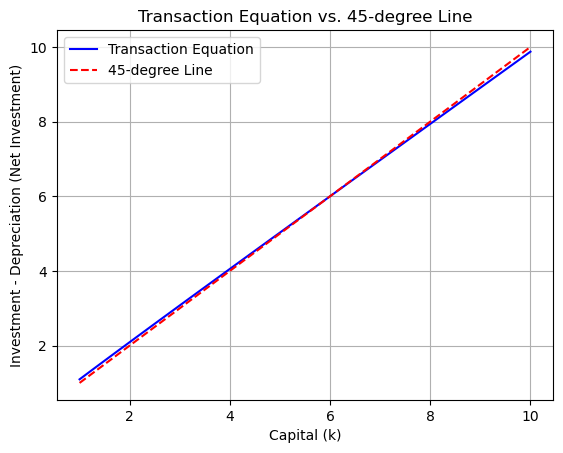

In [5]:
# Define the transaction equation
def transaction_equation(k, s, alpha, delta, n, phi):
    return (1/(1+n))*k*(s*k**(alpha-1)+(1-delta))**(1-phi)

# Define the 45-degree line
def forty_five_degree_line(k):
    return k

# Define our baseline paramters
s = 0.3
n = 0.02
delta = 0.05
alpha = 0.33
phi = 0.5

# Generate a range of k values
k_values = np.linspace(1, 10, 100)

# Calculate corresponding values for the transaction equation and 45-degree line
transaction_values = transaction_equation(k_values, s, alpha, delta, n, phi)
forty_five_degree_values = forty_five_degree_line(k_values)

# Plotting
plt.plot(k_values, transaction_values, label='Transaction Equation', color='blue')
plt.plot(k_values, forty_five_degree_values, label='45-degree Line', linestyle='--', color='red')

# Labeling and customization
plt.title('Transition Equation vs. 45-degree Line')
plt.xlabel('Capital (k)')
plt.ylabel('Investment - Depreciation (Net Investment)')
plt.legend()
plt.grid(True)
plt.show()


In this graph we can see the transition line crosses the 45-degree lin. At this point we find the steady state values for the given paremeters. This is because capital accumulation has gotten bigger so the depreasion of capital is larger in real values. 

## Parameter calibrations

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

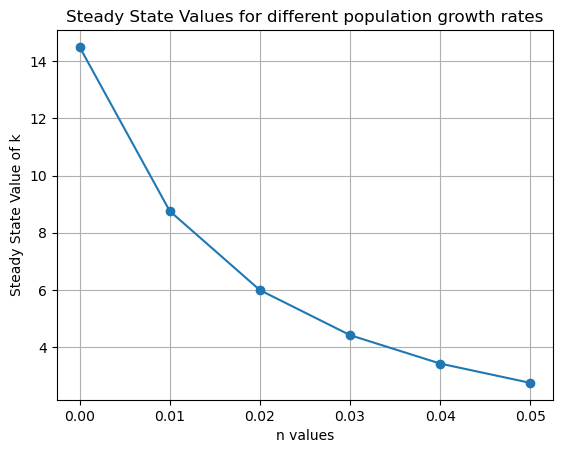

In [6]:
# We create a list for different values of n, so we can see how it effects the steady state
n_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05]

# Create a empty list for the steady states 
steady_states = []

# Calculate steady state for each n value
for n in n_values:
    obj_kss = lambda k: k - (1/(1+n))*k*(s*k**(alpha-1)+(1-delta))**(1-phi)
    result = optimize.root_scalar(obj_kss, bracket=[0.1, 100], method='brentq')
    steady_states.append(result.root)

# Plotting
plt.plot(n_values, steady_states, marker='o')
plt.title('Steady State Values for different population growth rates')
plt.xlabel('n values')
plt.ylabel('Steady State Value of k')
plt.grid(True)
plt.show()

In this graph we can see the steady state value of k becomes smaller when there is more population growth. This is because of thinning of capital because more workers are splitting the capital. 

**BESKRIV PLOT**

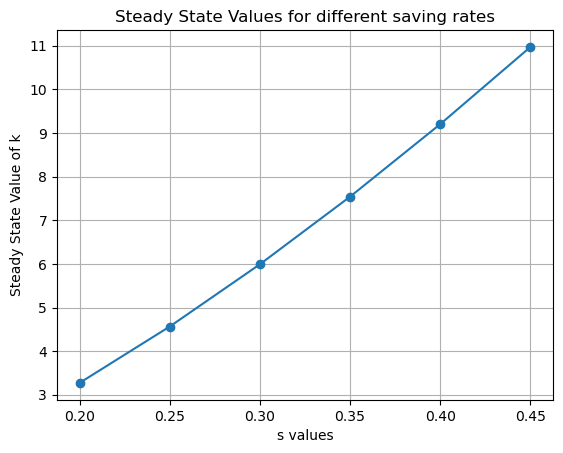

In [7]:
# We create a list for different values of s, so we can see how it effects the steady state
s_values = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45]

# We make sure that n is equal to our baseline model
n = 0.02

# Create a empty list for the steady states 
steady_states = []

# Calculate steady state for each n value
for s in s_values:
    obj_kss = lambda k: k - (1/(1+n))*k*(s*k**(alpha-1)+(1-delta))**(1-phi)
    result = optimize.root_scalar(obj_kss, bracket=[0.1, 100], method='brentq')
    steady_states.append(result.root)

# Plotting
plt.plot(s_values, steady_states, marker='o')
plt.title('Steady State Values for different saving rates')
plt.xlabel('s values')
plt.ylabel('Steady State Value of k')
plt.grid(True)
plt.show()

In this graph we see the values for saving rates and the steady state for capital. We can see when saving rates grows the capital also goes up. In this model we are in a closed-economy which means savings = capital and this is therefore not surprising

**Beskriv plot**

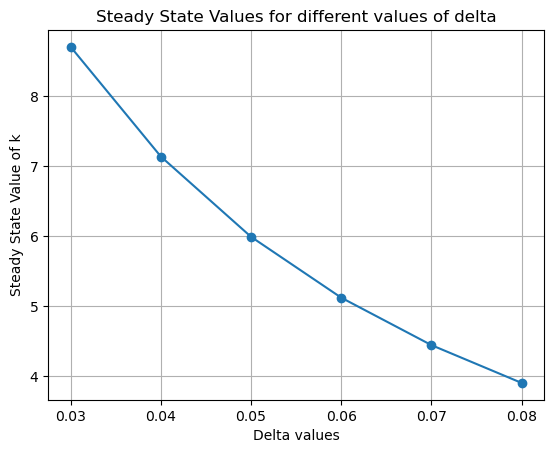

In [8]:
# We create a list for different values of delta, so we can see how it effects the steady state
delta_values = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

# We make sure that s is equal to our baseline model
s = 0.3

# Create a empty list for the steady states 
steady_states = []

# Calculate steady state for each n value
for delta in delta_values:
    obj_kss = lambda k: k - (1/(1+n))*k*(s*k**(alpha-1)+(1-delta))**(1-phi)
    result = optimize.root_scalar(obj_kss, bracket=[0.1, 100], method='brentq')
    steady_states.append(result.root)

# Plotting
plt.plot(delta_values, steady_states, marker='o')
plt.title('Steady State Values for different values of delta')
plt.xlabel('Delta values')
plt.ylabel('Steady State Value of k')
plt.grid(True)
plt.show()

This graph showes the state state values of k when chaning values for capital deprescion. We can see when the values of delta increses the steady state value falls. This is because a bigger part of the captial will be destroyed each year, so there will be a smaller amount of capital in the steady state. 

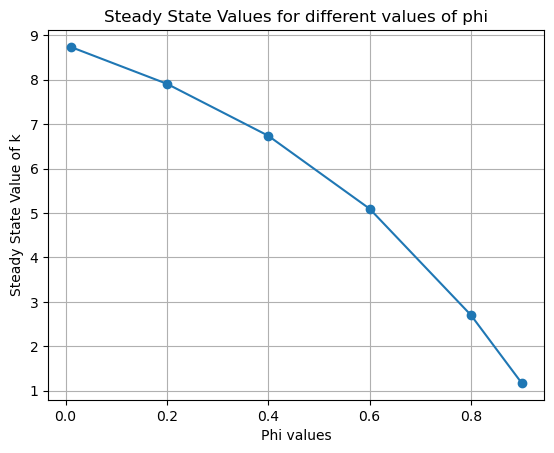

In [12]:
# We create a list for different values of delta, so we can see how it effects the steady state
phi_values = [0.01, 0.2, 0.4, 0.6, 0.8, 0.9]

# We make sure that delta is equal to our baseline model
delta = 0.05

# Create a empty list for the steady states 
steady_states = []

# Calculate steady state for each n value
for phi in phi_values:
    obj_kss = lambda k: k - (1/(1+n))*k*(s*k**(alpha-1)+(1-delta))**(1-phi)
    result = optimize.root_scalar(obj_kss, bracket=[0.1, 100], method='brentq')
    steady_states.append(result.root)

# Plotting
plt.plot(phi_values, steady_states, marker='o')
plt.title('Steady State Values for different values of phi')
plt.xlabel('Phi values')
plt.ylabel('Steady State Value of k')
plt.grid(True)
plt.show()

**Beskriv plot, modsat retning?**

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 